# Assignment 2: Convergence, Accounting, & Development

**GLBL 5010: Economics for Global Affairs**

**Group Members:**
* Kevin Chen
* Pranav Pattatathunaduvil
* Lucy Kim

---

# Data Cleaning

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

# Choosing country code for later question
MY_COUNTRY_CODE = "USA"

# Load the data
df = pd.read_csv("hwk2_accounting.csv", sep="\t")

# Filter for rows that have data for both 1960 and 2018 to ensure consistent samples
df = df.dropna(subset=["pop1960", "cgdpo1960", "cn1960", "pop2018", "cgdpo2018", "cn2018"]).copy()

print("Data loaded. Number of countries:", len(df))
print(df.head())

Data loaded. Number of countries: 102
  countrycode    country    pop1960    hc1960  cgdpo1960      cn1960  \
3         ARG  Argentina  20.545674  1.953866    65001.0  107963.000   
5         AUS  Australia  10.470019  2.746758   163815.0  744405.700   
6         AUT    Austria   7.093828  2.403941    71811.0  176051.700   
7         BDI    Burundi   2.781159  1.095495     1920.0    5961.864   
8         BEL    Belgium   9.113383  2.307354    94903.0  493083.300   

     pop2018    hc2018  cgdpo2018      cn2018                     region  
3  44.361150  3.065968    1022236  3361087.00  Latin America & Caribbean  
5  24.898152  3.536047    1350340  5795477.00        East Asia & Pacific  
6   8.891388  3.369997     470542  2835065.00      Europe & Central Asia  
7  11.175374  1.402834       9048    18111.23         Sub-Saharan Africa  
8  11.482178  3.142735     510223  3436160.00      Europe & Central Asia  


---
# 1A

The production function is $Y=AK^{\alpha}L^{1-\alpha}$.

To express this in GDPPC, we simply divided by $L$

We"re also keeping in mind the lowercase variables ($y=Y/L$ and $k=K/L$)

$$\frac{Y}{L} = A \left(\frac{K}{L}\right)^\alpha \frac{L^{1-\alpha}}{L^{1-\alpha}}$$

$$y = A k^\alpha$$

--- 
# 1B

In [16]:
# Create GDPPC for 1960 and 2018
df["y_1960"] = df["cgdpo1960"] / df["pop1960"]
df["y_2018"] = df["cgdpo2018"] / df["pop2018"]

# Create log variables
df["ln_y_1960"] = np.log(df["y_1960"])
df["ln_y_2018"] = np.log(df["y_2018"])

# Calculate Growth (Difference in logs)
df["growth"] = df["ln_y_2018"] - df["ln_y_1960"]

# Run OLS regression of growth based on initial log GDPPC (1960)
reg_1b = smf.ols("growth ~ ln_y_1960", data=df).fit()
print(reg_1b.summary())

                            OLS Regression Results                            
Dep. Variable:                 growth   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.816
Date:                Sat, 24 Jan 2026   Prob (F-statistic):              0.181
Time:                        10:28:36   Log-Likelihood:                -132.01
No. Observations:                 102   AIC:                             268.0
Df Residuals:                     100   BIC:                             273.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.3232      0.726      3.198      0.0


**Interpretation**

The coefficient on "ln_y_1960" is **-0.1214**.

While the coefficient is negative, which would typically suggest convergence (poorer countries growing faster), the p-value is **0.181**. 

Because this is >0.05, the result is **not statistically significant**, therefore we do not find strong evidence of convergence across this sample data of countries.

--- 
# 1C


In [17]:
# initialize alpha 
alpha = 0.30

# calculate k for both years
df["k_1960"] = df["cn1960"] / df["pop1960"]
df["k_2018"] = df["cn2018"] / df["pop2018"]

# log k
df["ln_k_1960"] = np.log(df["k_1960"])
df["ln_k_2018"] = np.log(df["k_2018"])

# calculate TFP (ln A)
# Formula: ln y = ln A + alpha * ln k  =>  ln A = ln y - alpha * ln k
df["ln_A_1960"] = df["ln_y_1960"] - alpha * df["ln_k_1960"]
df["ln_A_2018"] = df["ln_y_2018"] - alpha * df["ln_k_2018"]

# mean and std dev of ln A for 1960
print("1960 ln A Statistics:")
print(df["ln_A_1960"].describe()[["mean", "std"]])

1960 ln A Statistics:
mean    5.366537
std     0.620780
Name: ln_A_1960, dtype: float64


---
# 1D

Correlation between ln y and ln A (1960): 0.9406


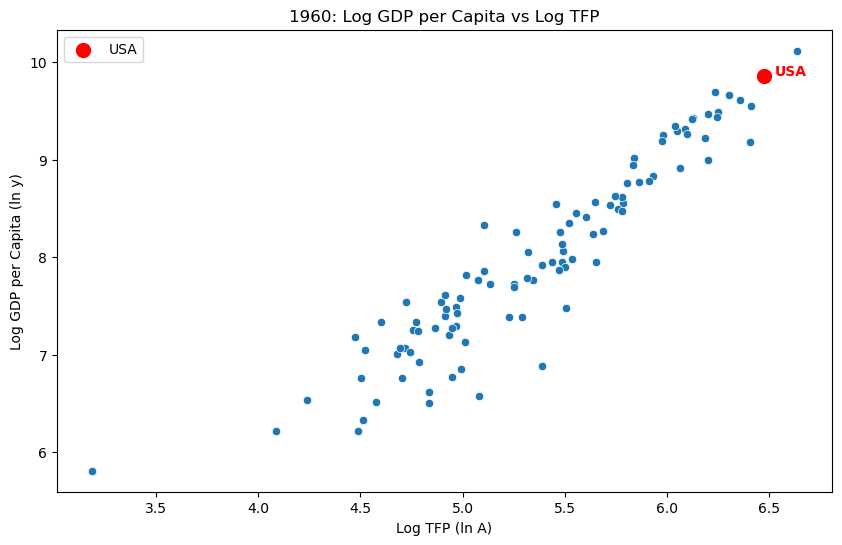

In [ ]:
# correlation between ln y and ln A for 1960
corr_1d = df["ln_y_1960"].corr(df["ln_A_1960"])
print(f"Correlation between ln y and ln A (1960): {corr_1d:.4f}")

# scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(x="ln_A_1960", y="ln_y_1960", data=df)

# isolating the USA data point
my_data = df[df["countrycode"] == "USA"]
if not my_data.empty:
    plt.scatter(my_data["ln_A_1960"], my_data["ln_y_1960"], color="red", s=100, label=MY_COUNTRY_CODE)
    plt.text(my_data["ln_A_1960"].values[0]+0.05, my_data["ln_y_1960"].values[0], MY_COUNTRY_CODE, color="red", weight="bold")

plt.title("1960: Log GDP per Capita vs Log TFP")
plt.xlabel("ln A (TFP)")
plt.ylabel("ln y (GDP per Capita)")
plt.legend()
plt.show()

The correlation for the United States is **~0.94**.

The United States is located in the top right upper cluster which indicates **high TFP and high income**.

--- 

# 1E

(Made the mistake of using the US as our sample country, so for this example alone we will analyze Canada)

In [20]:
# calculate US TFP for 2018
us_tfp_2018 = df.loc[df["countrycode"] == "USA", "ln_A_2018"].values[0]
print(f"USA TFP (2018): {us_tfp_2018:.4f}")

# isolate ln y for 2018 using US TFP
df["ln_y_2018_hyp"] = us_tfp_2018 + alpha * df["ln_k_2018"]

# Canada for our example and isolating based on country code
target_country = "CAN"

hyp_ln_y = df.loc[df["countrycode"] == target_country, "ln_y_2018_hyp"].values[0]
hyp_gdp_val = np.exp(hyp_ln_y)
actual_ln_y_1960 = df.loc[df["countrycode"] == target_country, "ln_y_1960"].values[0]

# calculate hypothetical growth variable
hyp_growth = hyp_ln_y - actual_ln_y_1960

# printing stats
print(f"--- {target_country} Hypothetical Results ---")
print(f"Hypothetical ln y (2018): {hyp_ln_y:.4f}")
print(f"Hypothetical GDP per capita (2018): ${hyp_gdp_val:,.2f}")
print(f"Hypothetical Growth (1960-2018): {hyp_growth:.4f}")

USA TFP (2018): 7.3540
--- CAN Hypothetical Results ---
Hypothetical ln y (2018): 11.0587
Hypothetical GDP per capita (2018): $63,493.33
Hypothetical Growth (1960-2018): 1.4441


**Answer:**
If Canada had US-level TFP in 2018:
* Hypothetical log GDP: **~11.06**
* Hypothetical GDP ($): **$63,493.33**
* Hypothetical Growth: **~1.44**

---
# 1F

In [ ]:
# calculate hypothetical growth for all countries with 2018 and 1960 data
df["growth_hyp"] = df["ln_y_2018_hyp"] - df["ln_y_1960"]

# run Regression of differences
reg_1f = smf.ols("growth_hyp ~ ln_y_1960", data=df).fit()
print(reg_1f.summary())

                            OLS Regression Results                            
Dep. Variable:             growth_hyp   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     437.6
Date:                Sat, 24 Jan 2026   Prob (F-statistic):           2.64e-38
Time:                        10:40:13   Log-Likelihood:                -27.428
No. Observations:                 102   AIC:                             58.86
Df Residuals:                     100   BIC:                             64.11
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.9687      0.261     30.581      0.0

**Interpretation:**

The new coefficient on "ln_y_1960" is **-0.6763**.

Comparing this to the result in 1B (which was -0.1214 and not significant), this new coefficient is **much more negative and highly statistically significant**.

This implies that if all countries had the same level of TFP (specifically, the US level), there would be **very strong unconditional convergence**. The fact that we don't see this convergence in reality implies that **TFP differences** are the primary reason why poorer countries are not catching up to richer ones.